# 🏠📈House Price Regression using XGBoost

In this notebook, each row is a house and each column is a feature of that house, and by using these features, we want to teach our XGBoost model to be able to estimate the price of a house, bacsed on the given info about it.

As you know, this is a regression problem.

What we're gonna be doing in this notebook:
* Installing XGBoost
* Importing librabies and data
* Data understanding and preparation
* EDA
* Creating X & y variables
* Split our data into train and test sets
* Create the model and fit the data into it
* Predict on the test data
* Using Mean Absolute Error for XGBoost model
* Extracting feature importace
* Try another model (SVR)

## Installing XGBoost


In [1]:
!pip install xgboost

## Importing librabies and data

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('drive/MyDrive/XGBoost/kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

As you can see, we have 21613 rows and 21 columns.

## Data understanding and preparation

we don't have any null values! BUT WAIT! Maybe the "0" value in some columns means this is null! For example in `sqft_basement` or `yr_renovated`

So what if we wanted to fill these null values?

Well what we can do for `yr_renovated` is that we can fill "0" values with the values in `yr_built` column.

Another thing is dealing with categirical columns. For example `zipcode` is categorical (although it looks like it's numeric). The problem with `zipcode` is that even if we encode it using One Hot Encoder, it would be still useless. Why you may ask?! Well, bacause it's not repeating. it's a unique code for each house. So if we bring new rows (new houses), all those encoded zipcode columns would be zero! So we can delete this column since it's not gonna give us any usefull information.

In [9]:
# Replace 0 values in column 'yr_renovated' with corresponding values from column 'yr_built'
data.loc[data['yr_renovated'] == 0, 'yr_renovated'] = data['yr_built']

# Dropping the `zipcode` column
data.drop('zipcode', axis=1, inplace=True)

data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1965,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987,47.6168,-122.045,1800,7503


## EDA

In [10]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,1973.386018,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,28.806854,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,1900.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,1954.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,1977.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,1999.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,47.777600,-121.315000,6210.000000,871200.000000


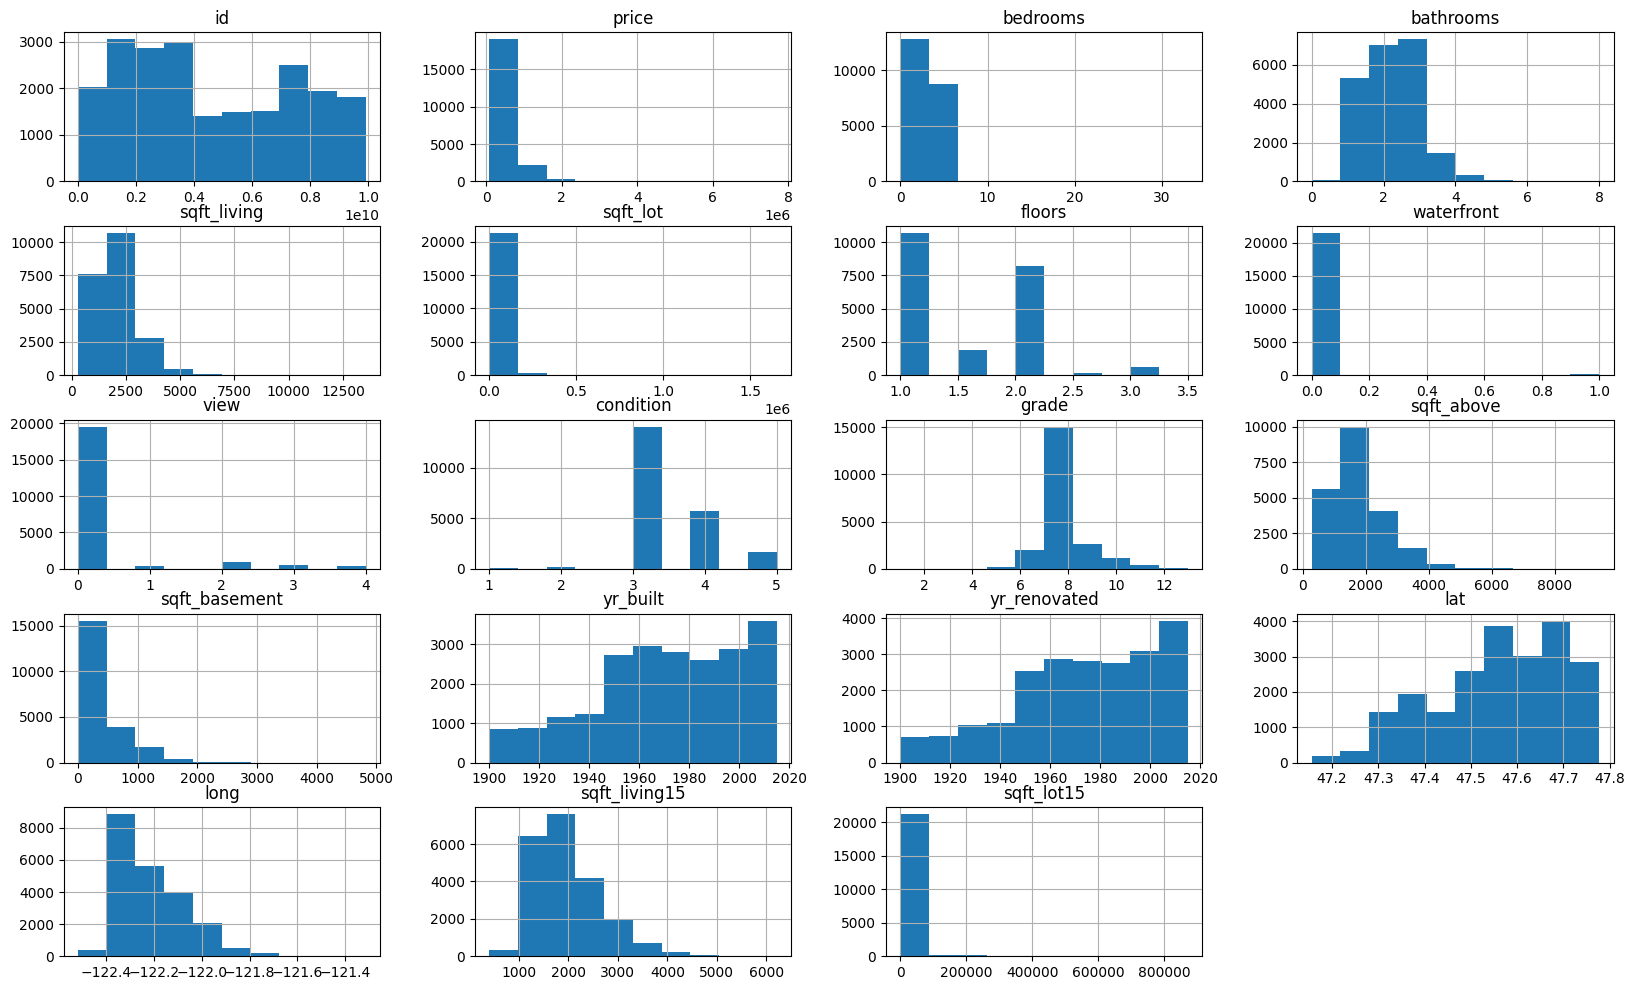

In [11]:
data.hist(figsize=(20, 12));

## Creating X & y variables

In [12]:
# We don't need Id and date
X = data.iloc[:, 3:].values
y = data['price'].values

In [13]:
np.shape(y)

(21613,)

## Split our data into train and test sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Create the model and fit the data into it

In [16]:
xg_reg = xgb.XGBRegressor(colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=1000, verbosity=3)

In [17]:
xg_reg.fit(X_train, y_train)

[08:07:04] ======== Monitor (0): HostSketchContainer ========
[08:07:04] AllReduce: 0.013715s, 1 calls @ 13715us

[08:07:04] MakeCuts: 0.027779s, 1 calls @ 27779us

[08:07:04] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[08:07:09] ======== Monitor (0): Learner ========
[08:07:09] Configure: 0.051199s, 1 calls @ 51199us

[08:07:09] EvalOneIter: 0.010443s, 1000 calls @ 10443us

[08:07:09] GetGradient: 0.060073s, 1000 calls @ 60073us

[08:07:09] PredictRaw: 0.001449s, 1000 calls @ 1449us

[08:07:09] UpdateOneIter: 4.44821s, 1000 calls @ 4448208us

[08:07:09] ======== Monitor (0): GBTree ========
[08:07:09] BoostNewTrees: 4.28366s, 1000 calls @ 4283658us

[08:07:09] CommitModel: 0.001206s, 1000 calls @ 1206us

[08:07:09] ======== Monitor (0): HistUpdater ========
[08:07:09] BuildHistogram: 0.933918s, 5000 calls @ 933918us

[08:07:09] EvaluateSplits: 1.89924s, 6000 calls @ 1899238us

[08:07:09] InitData: 0.080128s, 1000 calls @ 80128us

[08:07:09] InitRoot: 0.503333s, 1000

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Predict on the test data

In [18]:
y_pred = xg_reg.predict(X_test)

[08:11:01] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


## Using Mean Absolute Error

Metric tools in regression problems are a bit different. Because here we can't make confusion matrix.

One of the metrics in regression problems are Mean Absolute Error. It shows the mean error of the test data evaluation.

In [19]:
metrics.mean_absolute_error(y_test, y_pred)

64392.04190472335

Now there's a big question you gotta ask yourself:

> Is this number low enough to trust and rely on the model?

Well to answer this question we have to compare this error number with the mean and STD of `price` column.




In [20]:
data['price'].mean()

540088.1417665294

In [21]:
data['price'].std()

367127.1964826997

So if we look at it this way, the error number now looks more reasonable! I mean it's fine. Imagine the price of a house would be `$900,000` and our model would predict it `$960,000`. It's still a nice prediction right?!

## Extracting feature importace

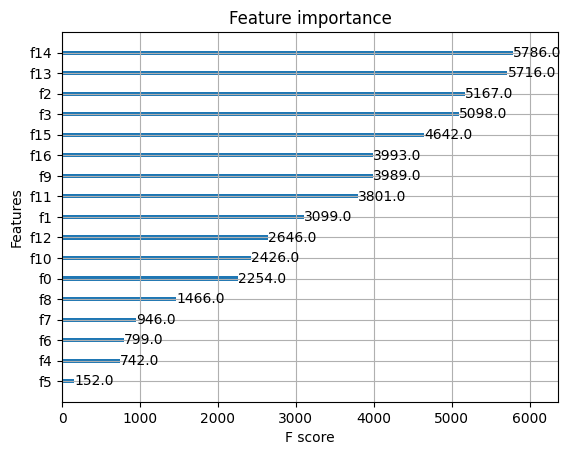

In [23]:
xgb.plot_importance(xg_reg);

## Try another model (SVR)

In [24]:
from sklearn.svm import SVR
s = SVR()
s.fit(X_train, y_train)
y_pred = s.predict(X_test)

In [25]:
metrics.mean_absolute_error(y_test, y_pred)

216963.09185937213

Well now we're talking about a bad error number!!!

So clearly, XGBoost model was way better!

**Thanks For Your Attention**

<div style=" padding: 40px; text-align: left; color: #535453;">
    Notebook by:
    <h2 style="font-family: 'calibri', sans-serif;ext-align: center;  font-size: 50px; margin-top: 0; margin-bottom: 20px;">
    Elyas Najafi
    </h2>
</div>